In [42]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
%matplotlib inline
import pandas as pd

In [70]:
import json
from pprint import pprint

def getGameJSON(path):
    with open(path) as data_file:    
        data = json.load(data_file)
    return data
        
data = getGameJSON('GSWvsCLE.json')


In [5]:
def getHomeVisitorIds(data):
    visitors = data['events'][0]['visitor']['players']
    home = data['events'][0]['home']['players']

    visitor_ids = []
    home_ids = []


    for visitor in visitors:
        visitor_ids.append(visitor['playerid'])    

    for homie in home:
        home_ids.append(homie['playerid'])  

    return {'visitor': visitor_ids, 'home': home_ids}

getHomeVisitorIds(data)

{'home': [201567,
  2592,
  202681,
  202697,
  2747,
  203521,
  203099,
  202684,
  2760,
  202389,
  2544,
  2210,
  2590],
 'visitor': [201574,
  201575,
  201578,
  2738,
  202691,
  101106,
  2571,
  203546,
  203110,
  201939,
  203105,
  2733,
  203084]}

In [9]:
# read in the court png file
court = plt.imread("fullcourt.png")

headers = ["team_id", "player_id", "x_loc", "y_loc", 
           "radius"]

def playerDFtoList(frame):
    xList = frame['x_loc'].tolist()
    yList = frame['y_loc'].tolist()
    bothList = []
    for i in range(len(xList)):
        bothList.append([ xList[i], yList[i] ])
    return np.array(bothList)

In [11]:
def getMoments(data):
    player_moments = []
    for event in data['events']:
        for moment in event['moments']:
            for player in moment[5]:
                player_moments.append(player)

    df = pd.DataFrame(player_moments, columns=headers)
    return df


In [ ]:
def calculateDistance(x1,y1,x2,y2):
     dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
     return dist

def distanceAndHandler(moment):
    
    df = getMoments(moment)
    df['DistanceToBall'] = 0.0
    df['DistanceToBasket'] = 0.0
    df['HandlerId'] = 0.0
    handler = ''
    shortest_distance = 100.0
    basket1 = [5.32, 24.8]
    basket2 = [88.55, 24.8]
    halfcourt = 47.0
    
    num_plays = 4
        
    for j in range(0,num_plays):
        index = j + j*10
        
        play = df[index : index + 10]
                
        ballX = df.x_loc[index]
        ballY = df.y_loc[index]

        if ballX > halfcourt:
            dist = calculateDistance(ballX, ballY, basket2[0], basket2[1])
        elif ballX < halfcourt:
            dist = calculateDistance(ballX, ballY, basket1[0], basket1[1])
        
        df.DistanceToBasket[index] = dist
        
        for i in range(index, index+11):
            ballX = df.x_loc[index]
            ballY = df.y_loc[index]
            distToBall = float(calculateDistance(df.x_loc[i], df.y_loc[i], ballX, ballY))
            df.DistanceToBall[i] = float(distToBall)

            if distToBall > 0.0 and distToBall < shortest_distance:
                shortest_distance = distToBall
                handler = df.player_id[i]
    
            df.HandlerId[index] = handler
        
    return df


data = getGameJSON('GSWvsCLE.json')
distanceAndHandler(data).head(44)

/home/keenan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/keenan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/keenan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/keenan/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to b

In [104]:
def teamOnOffense(moment):
    
    df = getMoments(moment)

    halfcourtX = 47.0
    if df.x_loc[0] > halfcourtX:
        return df.team_id[6]
    elif df.x_loc[0] < halfcourtX:
        return df.team_id[1]

data = getGameJSON('GSWvsCLE.json')
teamOnOffense(data)

1610612739

In [103]:
def distanceToBasket(moment):
    basket1 = [5.32, 24.8]
    basket2 = [88.55, 24.8]
    halfcourt = 47.0
    
    ballX = moment.x_loc[0]
    ballY = moment.y_loc[0]
    
    if ballX > halfcourt:
        dist = calculateDistance(ballX, ballY, basket2[0], basket2[1])
        return dist
    elif ballX < halfcourt:
        dist = calculateDistance(ballX, ballY, basket1[0], basket1[1])
        return dist    
    
data = getGameJSON('GSWvsCLE.json')
df = getMoments(data)
distanceToBasket(df[0:11])

31.118304104743558

In [71]:
# Get moments from the zeroth event
player_moments = []
for event in data['events']:
    for moment in event['moments']:
        for player in moment[5]:
            player_moments.append(player)

df = pd.DataFrame(player_moments, columns=headers)

# Get specific player's movements
ball = df[df.player_id==-1]

steph = df[df.player_id==201939]
klay = df[df.player_id==202691]
bogut = df[df.player_id==101106]
green = df[df.player_id==203110]
barnes = df[df.player_id==203084]

lebron = df[df.player_id==2544]
smith = df[df.player_id==2747]
love = df[df.player_id==201567]
irving = df[df.player_id==202681]
mozgov = df[df.player_id==202389]

# convert them to numpy arrays
ballA = playerDFtoList(ball)

stephA = playerDFtoList(steph)
klayA = playerDFtoList(klay)
bogutA = playerDFtoList(bogut)
greenA = playerDFtoList(green)
barnesA = playerDFtoList(barnes)

lebronA = playerDFtoList(lebron)
smithA = playerDFtoList(smith)
loveA = playerDFtoList(love)
irvingA = playerDFtoList(irving)
mozgovA = playerDFtoList(mozgov)

#Get ball radiuses
radii = ball['radius'].tolist()

In [72]:
class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, playerLists, ballRadii):
        self.numpoints = len(playerLists)
        print 'numpoints:',self.numpoints
        self.stream = self.data_stream()

        self.ballRadii = ballRadii
        
        locations = []
        for i in range(len(playerLists[0])):
            # For each moment
            locations.append([])
            for player in playerLists:
                try:
                    locations[i].append(player[i])
                except IndexError:
                    break
        self.locations = locations
    
        if self.numpoints == 11:
            self.colorArray = np.array([0,1,1,1,1,1,2,2,2,2,2])
        else:
            self.colorArray = np.array([0] + [2]*(self.numpoints-1))
        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=25, 
                                           init_func=self.setup_plot, blit=True)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        pos, c, i,r = next(self.stream)
        self.scat = self.ax.scatter(2, 40, animated=True)
        self.ax.axis([0, 94, 50, 0])
#         self.ax.legend(['Event'])
        
#         self.eventnumber = plt.annotate("Event: 0", xy =(20, 30), zorder=1)

        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

    def data_stream(self):
        """Generate a random walk (brownian motion). Data is scaled to produce
        a soft "flickering" effect."""
        data = [[[],[],[]],[],[],[]]
        data[1] = self.colorArray
        
        i = 0
        while True:
            data[0] = self.locations[i]
            data[2] = i # this event number
            data[3] = self.ballRadii[i]
            i += 1
            yield data

    def update(self, i):
        """Update the scatter plot."""
        data = next(self.stream)

        # Set x and y data...
        self.scat.set_offsets(data[0])
        # Set sizes...
        self.scat._sizes = np.array([data[3]*4,120,120,120,120,120,120,120,120,120,120])
        # Set colors..
        self.scat.set_array(data[1])
        
        self.scat.set_label("Event man")
        
#         self.eventnumber.remove()
#         self.eventnumber = plt.annotate("Event: "+str(data[2]), xy =(20, 30), zorder=1)
#         draw()
        
#         self.scat.axes.legend(['poop'])

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

    def show(self):
        plt.imshow(court, zorder=0, extent=[0,94,50,0])
        plt.show()

numpoints: 11


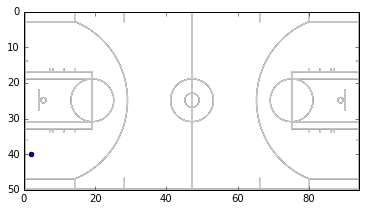

In [73]:
a = AnimatedScatter([ballA, stephA, klayA, bogutA, greenA, barnesA, lebronA, smithA, loveA, irvingA, mozgovA],radii)
# a = AnimatedScatter([ballA, irvingA, stephA])
# a = AnimatedScatter([irvingA])
a.show()

In [50]:
just ball:
[
    [[28.64068], [45.403269999999999]],
    [[28.52319], [45.279890000000002]],
    [[28.38205], [45.163530000000002]]
]


with both:
[
    [[28.64068, 27.874120000000001], [45.403269999999999, 45.489800000000002]],
    [[28.52319, 27.793469999999999], [45.279890000000002, 45.431060000000002]],
    [[28.38205, 27.717929999999999], [45.163530000000002, 45.364379999999997]]
]

SyntaxError: invalid syntax (<ipython-input-50-0b0a0bc956e4>, line 1)